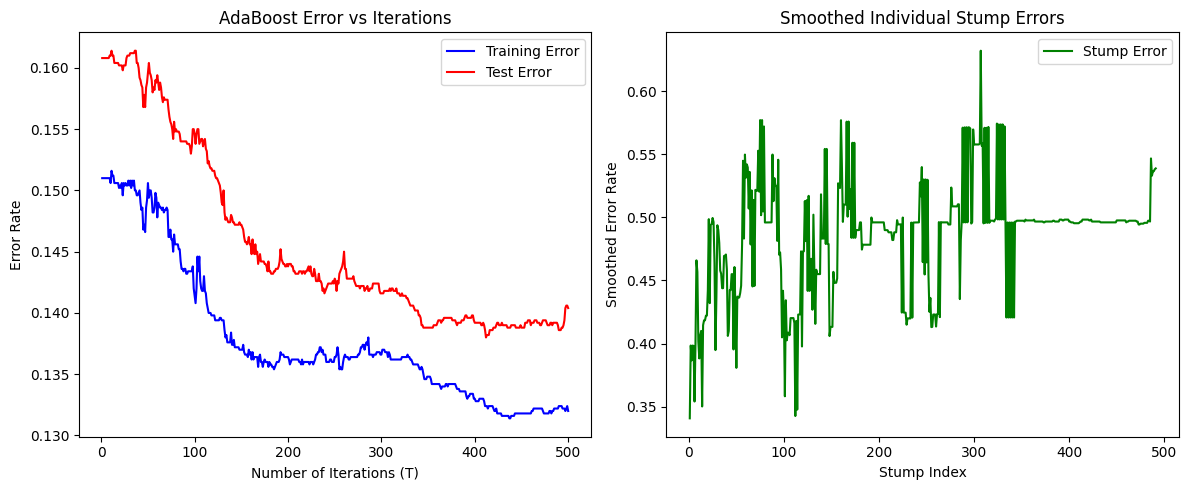

In [9]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Function to Identify Feature either Numerical or Categorical.
def identify_feature_types(data_matrix):
    feature_categories = []
    for i in range(data_matrix.shape[1]):
        if np.issubdtype(data_matrix[:, i].dtype, np.number):
            feature_categories.append("numerical")
        else:
            feature_categories.append("categorical")
    return feature_categories
# Function to partition the data based on lower and upper split.
def partition_data(data_matrix, feature_idx, threshold_value):
    lower_split = data_matrix[:, feature_idx] <= threshold_value
    upper_split = ~lower_split
    return lower_split, upper_split
# Function to calculate Entropy
def compute_entropy(labels, sample_weights):
    total_weight = np.sum(sample_weights)
    label_counts = Counter(labels)
    entropy_score = 0.0
    for label in label_counts:
        weighted_label_count = np.sum(sample_weights[labels == label])
        prob = weighted_label_count / total_weight
        if prob > 0:
            entropy_score -= prob * np.log2(prob)
    return entropy_score
# Function to calculate IG
def calculate_information_gain(labels, left_labels, right_labels, left_weights, right_weights, sample_weights):
    parent_entropy = compute_entropy(labels, sample_weights)
    left_entropy = compute_entropy(left_labels, left_weights)
    right_entropy = compute_entropy(right_labels, right_weights)
    weighted_child_entropy = (np.sum(left_weights) / np.sum(sample_weights)) * left_entropy + \
                             (np.sum(right_weights) / np.sum(sample_weights)) * right_entropy
    return parent_entropy - weighted_child_entropy

def construct_decision_stump(data_matrix, labels, sample_weights, threshold_count=20, feature_sampling_rate=0.8):
    num_samples, num_features = data_matrix.shape
    optimal_feature = None
    optimal_threshold = None
    highest_gain = -np.inf
    optimal_predictions = None

    feature_types = identify_feature_types(data_matrix)

    # Used for random feature selection
    sampled_features = np.random.choice(num_features, int(feature_sampling_rate * num_features), replace=False)

    for feature in sampled_features:
        if feature_types[feature] == "numerical":
            distinct_values = np.unique(data_matrix[:, feature])
            if len(distinct_values) > threshold_count:
                thresholds = np.quantile(distinct_values, np.linspace(0, 1, threshold_count + 2)[1:-1])
            else:
                thresholds = distinct_values

            for threshold in thresholds:
                lower_mask, upper_mask = partition_data(data_matrix, feature, threshold)

                if np.sum(lower_mask) == 0 or np.sum(upper_mask) == 0:
                    continue

                left_labels, right_labels = labels[lower_mask], labels[upper_mask]
                left_weights, right_weights = sample_weights[lower_mask], sample_weights[upper_mask]

                # Calculate information gain
                info_gain = calculate_information_gain(labels, left_labels, right_labels, left_weights, right_weights, sample_weights)

                if info_gain > highest_gain:
                    highest_gain = info_gain
                    optimal_feature = feature
                    optimal_threshold = threshold

                    # Let's declare left, right, and optimal to make predictions based on majority class
                    left_prediction = weighted_majority_class(left_labels, left_weights)
                    right_prediction = weighted_majority_class(right_labels, right_weights)
                    optimal_predictions = np.where(lower_mask, left_prediction, right_prediction)

    return {
        'feature': optimal_feature,
        'threshold': optimal_threshold,
        'gain': highest_gain,
        'predictions': optimal_predictions
    }

def weighted_majority_class(labels, sample_weights):
    unique_classes = np.unique(labels)
    class_weighted_counts = {cls: np.sum(sample_weights[labels == cls]) for cls in unique_classes}
    return max(class_weighted_counts.items(), key=lambda x: x[1])[0]
# Defining our Adaboost Algorithm
def Adaboost_algorithm(data_matrix, labels, iterations, threshold_count=20, min_alpha=1e-10):
    num_samples = data_matrix.shape[0]
    sample_weights = np.ones(num_samples) / num_samples

    weak_learners = []
    alpha_weights = []
    stump_errors = []

    for t in range(iterations):
        stump = construct_decision_stump(data_matrix, labels, sample_weights, threshold_count=threshold_count)
        stump_error = np.sum(sample_weights[stump['predictions'] != labels])

        if stump_error >= 0.5 or stump_error == 0:
            break

        # Calculate alpha based on the stump's error
        alpha_value = 0.5 * np.log((1 - stump_error) / (stump_error + min_alpha))

        # Update sample weights based on stump's predictions
        sample_weights *= np.exp(-alpha_value * labels * stump['predictions'])
        sample_weights /= np.sum(sample_weights)

        # Appending the stump and alpha value
        weak_learners.append(stump)
        alpha_weights.append(alpha_value)

        # Record training error for the current stump
        stump_errors.append(np.mean(stump['predictions'] != labels))

    return weak_learners, alpha_weights, stump_errors

def Adaboost_predictions(data_matrix, weak_learners, alpha_weights):
    num_samples = data_matrix.shape[0]
    final_predictions = np.zeros(num_samples)

    for stump, alpha in zip(weak_learners, alpha_weights):
        stump_predictions = np.full(num_samples, 1)
        lower_mask = data_matrix[:, stump['feature']] <= stump['threshold']
        stump_predictions[lower_mask] = -1
        final_predictions += alpha * stump_predictions

    return np.sign(final_predictions)

def execute_experiment(X_train, y_train, X_test, y_test, max_iters, threshold_count=20, smoothing_size=10):
    # Running or defined AdaBoost Algorithm
    weak_learners, alpha_weights, stump_errors = Adaboost_algorithm(X_train, y_train, max_iters, threshold_count=threshold_count)

    # Compute training and testing errors over iterations
    training_errors = []
    testing_errors = []

    for t in range(1, len(weak_learners) + 1):
        # Training error
        train_predictions = Adaboost_predictions(X_train, weak_learners[:t], alpha_weights[:t])
        training_errors.append(np.mean(train_predictions != y_train))

        # Testing error
        test_predictions = Adaboost_predictions(X_test, weak_learners[:t], alpha_weights[:t])
        testing_errors.append(np.mean(test_predictions != y_test))

    # Smooth individual stump errors using a rolling average
    if smoothing_size > 1:
        smoothed_stump_errors = np.convolve(stump_errors, np.ones(smoothing_size)/smoothing_size, mode='valid')
    else:
        smoothed_stump_errors = stump_errors

    # Plot results
    plt.figure(figsize=(12, 5))

    # Plot 1: Error vs Iterations
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(training_errors) + 1), training_errors, 'b-', label='Training Error')
    plt.plot(range(1, len(testing_errors) + 1), testing_errors, 'r-', label='Test Error')
    plt.xlabel('Total Iterations')
    plt.ylabel('Error Rate')
    plt.title('AdaBoost Error vs Iterations Comparison')
    plt.legend()

    # Plot 2: Individual Stump Errors
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(smoothed_stump_errors) + 1), smoothed_stump_errors, 'g-', label='Stump Error')
    plt.xlabel('Stump Index')
    plt.ylabel('Smoothed Error Rate')
    plt.title('Smoothed Individual Stump Errors')
    plt.legend()

    plt.tight_layout()
    plt.show()

def prepare_data(df):
    # Convert categorical variables to numerical values
    categorical_features = df.select_dtypes(include=['object']).columns
    for feature in categorical_features:
        df[feature] = pd.Categorical(df[feature]).codes
    return df

def main():
    # Mapping column
    column_headers = ['age', 'job', 'marital_status', 'education', 'default_status', 'balance',
                      'housing_loan', 'personal_loan', 'contact_type', 'day', 'month', 'call_duration',
                      'campaign_count', 'previous_contact_days', 'previous_outcome', 'label']

    training_data = pd.read_csv("train.csv", names=column_headers)
    testing_data = pd.read_csv("test.csv", names=column_headers)

    # PPreparing the data to test and clean
    training_data = prepare_data(training_data)
    testing_data = prepare_data(testing_data)

    # Prepare features and labels
    X_train = training_data.drop('label', axis=1).values
    y_train = np.where(training_data['label'] == 1, 1, -1)
    X_test = testing_data.drop('label', axis=1).values
    y_test = np.where(testing_data['label'] == 1, 1, -1)

    # Executing the final result
    execute_experiment(X_train, y_train, X_test, y_test, max_iters=500, threshold_count=20, smoothing_size=10)

if __name__ == "__main__":
    main()
